# Topic Modeling and Recommending Similar Stories

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

random_state=42 # to make sure its reproducible

from glob import glob
datafiles = glob('../../data/*')
datafiles

['../../data/stories_2019.csv', '../../data/reactions_2019.csv']

In [2]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaMulticore
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# loading the data
stories_data = pd.read_csv(datafiles[0])
print(stories_data.columns)
stories_data.head()

Index(['Id', 'Perspective', 'Age', 'Lgbtq', 'Race', 'Phone', 'Topic', 'Title',
       'Lede', 'Published at', 'Like', 'Cringey', 'Haha', 'Me too',
       'Interesting', 'Story texts', 'Link url', 'Link photo url',
       'Link title', 'Link site name', 'Link body'],
      dtype='object')


,Id,Perspective,Age,Lgbtq,Race,Phone,Topic,Title,Lede,Published at,...,Cringey,Haha,Me too,Interesting,Story texts,Link url,Link photo url,Link title,Link site name,Link body
0,2269,female,19.0,no,white,870,relationships,NaN,NaN,NaN,...,0,0,0,0,Well I was in my house and when I asked my eye...,NaN,NaN,NaN,NaN,NaN
1,2268,female,18.0,no,white,3253073887,bullying,NaN,I just need to work on my confidence,2020-01-06 00:00:00 UTC,...,1,1,1,1,My confident isnt the best. Its not with the w...,https://kidshealth.org/en/teens/self-esteem.html,NaN,How can I improve my self-esteem?,Teens Health,NaN
2,2267,female,18.0,yes,other,(304) 691-3740,puberty,NaN,NaN,NaN,...,0,0,0,0,His name is Jeffery but we call him jeff💖; I a...,NaN,NaN,NaN,NaN,NaN
3,2266,female,22.0,yes,white,0575809857,bullying,NaN,NaN,NaN,...,0,0,0,0,The was Robert My boyfriend ; Nothing really. ...,NaN,NaN,NaN,NaN,NaN
4,2265,female,15.0,yes,Latina,9793642515,puberty,NaN,NaN,NaN,...,0,0,0,0,They were my ex and I still loved him.💘But the...,NaN,NaN,NaN,NaN,NaN


## Cleaning the column names to make it easier to work with

In [4]:
# dropping duplicates if the text are the same
stories_data.drop_duplicates(subset=['Story texts'], inplace=True)

# renaming columns to make them easier to work with
drop_columns = [column for column in stories_data.columns if 'link' in column.lower()]
drop_columns.extend([ 'Title', 'Lede', 'Cringey', 'Haha', 'Me too', 'Interesting', 'Phone', 'Like'])
stories_data.drop(columns=drop_columns, inplace=True, errors='ignore')

stories_data.columns = [column.lower().replace(' ', '_') for column in stories_data.columns]
stories_data.rename(columns={
    'id':'story_id'
}, inplace=True)

print(stories_data.columns)
stories_data.info()

Index(['story_id', 'perspective', 'age', 'lgbtq', 'race', 'topic',
       'published_at', 'story_texts'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2014 entries, 0 to 2060
Data columns (total 8 columns):
story_id        2014 non-null int64
perspective     2014 non-null object
age             1548 non-null float64
lgbtq           1548 non-null object
race            1548 non-null object
topic           2014 non-null object
published_at    819 non-null object
story_texts     2013 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 141.6+ KB


In [5]:
# how many are missing data
stories_data.isna().sum()

story_id           0
perspective        0
age              466
lgbtq            466
race             466
topic              0
published_at    1195
story_texts        1
dtype: int64

In [6]:
# dropping the row that doenst have data for the text column since we're using the text column heavily
stories_data.dropna(subset=['story_texts'], inplace=True)

# resetting index since i dropped rows earlier
stories_data.reset_index(inplace=True)
stories_data.drop('index', axis=1, inplace=True)

## Cleaning the Text

1. lemmatizing the text
2. removing stop words
4. create n_grams
3. vectorizing the words to feed to the algorithm

In [7]:
stories_data['cleaned'] = stories_data.story_texts.str.replace('[^\w\s]','')

# getting the POS tags to feed to the lem
stories_data['pos_tagged'] = stories_data.cleaned.map(word_tokenize).map(pos_tag)

In [8]:
# sometimes topic modeling on the nouns only makes it easier to identify topics in documents
stories_data['nouns_only'] = stories_data['pos_tagged'].map(lambda x: [(word, tag[0].lower()) for word, tag in x if tag[0].lower() in ['n']])

In [9]:
lem = WordNetLemmatizer()

In [10]:
stories_data.nouns_only = stories_data['nouns_only'].map(lambda x: [lem.lemmatize(word, tag) for word, tag in x])
stories_data['nouns_only'] = stories_data.nouns_only.map(lambda x: ' '.join(word.lower() for word in x))

## Topic Modeling with different algorithms

In [11]:
stop_words = stopwords.words('english')
stop_words = [s.translate(str.maketrans('', '', string.punctuation)) for s in stop_words]

# additional stop words removing from corpus
additional_stop_words = ['im', 'idk', 'friend', 'nothing', 'meh', 'ha', 'hey', 'hi', 'ive', 'vjfjfjfc'
                        , 'umm']

In [12]:
#tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stop_words + additional_stop_words
                        , lowercase=True
                       , ngram_range=(1,2)
                       )

tfidf_dtm = tfidf.fit_transform(stories_data.nouns_only)

In [16]:
def display_topics(model, feature_names, no_top_words=10, topic_names=None):
    for index, topic in enumerate(model.components_):
        if not topic_names or not topic_names[index]:
            print("\nTopic ", index)
        else:
            print("\nTopic: '",topic_names[index],"'")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [17]:
n_components=8
tfidf_nmf = NMF(n_components=n_components
            , random_state=random_state)
tfidf_nmf_data = tfidf_nmf.fit_transform(tfidf_dtm)

In [18]:
display_topics(tfidf_nmf, tfidf.get_feature_names())


Topic  0
time, guy, day, school, relationship, boy, thing, crush, year, feeling

Topic  1
sex, sex sex, boyfriend, consent, boyfriend sex, condom, sexy, bed, sex nervous, sex time

Topic  2
girl, girl girl, girl school, boy, gender, crush, school, crush girl, weird, weird girl

Topic  3
good, act, good act, room good, girl good, room, dick, home good, boyfriend, sex good

Topic  4
people, everyone, people people, school, person, lot, lot people, way, thing, name

Topic  5
mom, period, puberty, bathroom, year, home, pad, hair, blood, dad

Topic  6
sad, boyfriend, home, home sad, school sad, school, sad someone, someone, hit sad, boyfriend sad

Topic  7
bad, dumb, bitch, bad bad, nobody, yes, puberty bad, yes bad, bitch bad, bad dumb


In [19]:
m, n = tfidf_nmf_data.shape

In [20]:
tfidf_nmf_df = pd.DataFrame(tfidf_nmf_data, columns=[f'topic_{num}' for num in range(n)])
tfidf_nmf_df['max_topic'] = tfidf_nmf_data.argmax(axis=1)
tfidf_nmf_df['max_topic'].value_counts()

0    745
5    383
4    281
2    175
1    145
6    122
3     89
7     73
Name: max_topic, dtype: int64

In [21]:
combined = pd.merge(stories_data, tfidf_nmf_df, left_index=True, right_index=True)

## Figuring out what the topics actually mean by looking at the stories

sorting the stories by the highest ranking to figure out what the topics mean

In [23]:
display_topics(tfidf_nmf, tfidf.get_feature_names())


Topic  0
time, guy, day, school, relationship, boy, thing, crush, year, feeling

Topic  1
sex, sex sex, boyfriend, consent, boyfriend sex, condom, sexy, bed, sex nervous, sex time

Topic  2
girl, girl girl, girl school, boy, gender, crush, school, crush girl, weird, weird girl

Topic  3
good, act, good act, room good, girl good, room, dick, home good, boyfriend, sex good

Topic  4
people, everyone, people people, school, person, lot, lot people, way, thing, name

Topic  5
mom, period, puberty, bathroom, year, home, pad, hair, blood, dad

Topic  6
sad, boyfriend, home, home sad, school sad, school, sad someone, someone, hit sad, boyfriend sad

Topic  7
bad, dumb, bitch, bad bad, nobody, yes, puberty bad, yes bad, bitch bad, bad dumb


In [25]:
topics = {}
topics['topic_0'] = 'crushes_on_guys'

In [26]:
combined.sort_values(by='topic_0', ascending=False).head()['story_texts'].tolist()

['I forgot ; 8; Can I face time you; Nice',
 'I have this one girl in school and she used to date this guy I like and then eventually my feelings kinda faded with my crush and I became more interested in this guy that I’ve liked since the sixth grade; The guy I’ve like for a long time thinks I hate him but when really that’s how I show my feelings; Well eventually the girl broke up with my old crush and then one day I find out she’s dating the guy I’ve always wanted. Now I see her wearing his jacket and holding his hand; Every time I see them together I can feel my heart breaking more and more each time. i just wondering maybe if I was braver he would be with me and not her',
 'My first time having sex, the guy I was with was very aware; and checked in with my the entire time. ; It felt very different from what I expected ; and I really appreciated that he took the time to ensure it was enjoyable for the both of us; I loved it; We kept going and both enjoyed it',
 'I am a gay guy and I

In [27]:
# combined.sort_values(by='topic_1', ascending=False).head()['story_texts'].tolist()
topics['topic_1'] = 'sex'
combined.sort_values(by='topic_1', ascending=False).head(20)['story_texts'].tolist()

['My friend ; Having sex; Fucking sexy; I just went for it; They fucked me so hard ; They fingered me',
 'Hey ; Idk; I forgot ; Idk; I had sex; Good ',
 'I don’t know ; I speak Spanish ; Do you like sex; 😰; 🥳👎; ☹️👎🇺🇸😘',
 'Me ; Sex ; Sex; Sex',
 'Sex; Sex; Sex; Sex; Sex',
 'Can we have sex; I want to have sex; I love sex; About sex; Good ; No body ',
 'I whated to have sex with them; I just did it; Have you ever had sex and do you what to have sex; He is going to have sex; Good; I asked my crush and I asked my my boyfriend ',
 'Idk; Because sex is fun and good; How big is your 🍆; Sex; Good; Keyon',
 'How and why sex is created; Well it was weird; I asked; That u should always have sex; Nervous; I fucking asked my boyfriend ',
 'does sex hurt when the dick goes in?; i wasnt scared i just went out and asked; i said does sex really hurt?; i learned that it sometimes do but not always; i felt like they didnt know anything; i asked my bestfriend about sex.',
 'Can I have sex with you¿; Well;

In [28]:
combined.sort_values(by='topic_2', ascending=False).head(10)['story_texts'].tolist()

['I don’t know ; I don’t know ; I don’t know ; I would say I’m a female ; Girl',
 "Hi; Girl ; I'm ok x; How old are ix; U",
 'I was 7 ; nothing; good; a girl ; umm',
 '11; My mum; Weird; A girl; I act,look,dress like a bad girl ',
 "I questioned my gender identity at 11. i was born a girl some times I wish I was a boy but I'm a girl😔; What made me question my gender was that being a girl is harder then being a boy. Theres so much girlS have to do that boys don't       ; I felt mad and depressed I hated life and I still hate It  ; I identify as a girl. I was born a girl I'm still a girl now ; I don't know what I look like or dress or act",
 'i was 11 when i started to question my sexuality; a girl said she thought i was pretty and i started questioning if it would be possible if i could ever like girls; confused at first but not disgusted; bisexual; all',
 'I was born a girl man ; Nothing I was born a girl man; I am a girl ; I am a girl and I was born a girl use your noggin ayy ; I am a

In [29]:
topics['topic_3'] = 'female_sexuality'
combined.sort_values(by='topic_3', ascending=False).head(10)['story_texts'].tolist()

['Yea; Good pleased; 13',
 'Hey; Who is this; Who is this; My ass; Good ; 💍',
 'What?; I don’t know ; Good ; I love you ; I SAID I LIKE YOU ',
 'Idk; Idk; Idk; Idk; Idk; Good',
 'Because ; 17; Idk; Good ',
 'My girlfriend ; Sex; Directly ; Good; We did it; Good',
 'H; I am a girl; Good; No; What',
 'My room; 😂😂; Good ',
 'I like🍆🍆🍆🍆🍆; Idk; Good; Idk; Act',
 'I was10; Ok; Good; Idk; Act']

In [30]:
topics['topic_4'] = 'social_situations_at_school'
combined.sort_values(by='topic_4', ascending=False).head(10)['story_texts'].tolist()

['People were judging me; Idk; Idk; Scared ; When I left; Adian',
 'I am so much taller than everyone at my school; People always seem to look at me weirdly and so many people say “omg your so tall” and i literally hate it so much ; They are all so much smaller than me and petite and I probably look like an ogre to them. I’m not fat, I’m just so tall and i hate it; I always feel so embarrassed and awkward and hate myself; The thing that makes me feel better is people saying i should model and i want to model; Pretty much everyone judges me',
 'I found out what it meant and I was like omg those people are so stupid. But then I thought what if I was bisexual or lesbian and I said to myself no I will never be.; Months later everyone had there boy crush and I didn’t so I wondered and then realised I was into girls and liked a girl in my class. I still haven’t figured out what to do and now a lot of people know and don’t know if I should change just because of what people will think of me; 

In [31]:
topics['topic_5'] = 'puberty_first_period'
combined.sort_values(by='topic_5', ascending=False).head(10)['story_texts'].tolist()

['I was 13 when I first got my period and I was really excited because my friends already had it and I wanted to relate to them so bad; I was at home and I remember I just woke up and went to the bathroom and I saw it ; I was really excited; I told my mom and she gave me a pad; I told my mom first because she was at home with me',
 'I was 15 I think ; I was in the bathroom I noticed and I told my mom she said  that I got my period ; I didn’t like it and I still don’t like it I hate it ; I told my mom and she explained everything ; My mom because she knows everything ',
 "I was 12 when I first got my period. ; It was scary because all of my cousins were at my house.; I cried because I didn't know what to do so I stayed in the bathroom until everyone left. ; My mom later came in and told me what to do.; When I told my dad he was shocked because he didn't know what to do.; But now I know how to track my period and know how to track my period, how to use pads, and what to do with cramps.",

In [32]:
topics['topic_6'] = 'feeling_sad'
combined.sort_values(by='topic_6', ascending=False).head(10)['story_texts'].tolist()

['Idk; I was talking ; Nothing ; Not to do it; Sad; I ask him ',
 'My friend ; She said i wish you were dead and called me a thot; Sad and mad ; Nothing ',
 'My boyfriend left me after we had ; Doing it; I’m not shee; Stuoidly; Sad; Sad',
 'At home ; Sad; Just now',
 'I don’t know ; Nothing ; Sad; I was sad ; I did ; I told someone ',
 'School; Sad but happy ; Last night ',
 'Home ; Sad ; Yesterday',
 'I like her; I’m not good ; Hi ; Nothing ; Sad; Molly',
 'Nothing ; I was not; Because they hate me; Sad; I need money please ; My boyfriend ',
 'School ; Hit me ; Sad; Called 911 ']

In [33]:
topics['topic_7'] = 'random/confusion'
combined.sort_values(by='topic_7', ascending=False).head(20)['story_texts'].tolist()

['I went puberty ; 7; I want boyfriend ; Bad',
 'I dint; I didn’t ; I love you; They said I love you back; Bad',
 "I was sexually assaulted...; Nothing. He didn't even ask me. ;( ; He didn't ; I didn't know what to do. ; I left. ; Bad. ",
 'Don’t know ; Because I like them; Hi; Bad; Bad!!',
 'ya ; Yes; No; I am hiding ; It was Tinkling; Bad',
 'I never went through puberty; 15; I was at least 16; Bad',
 'I wanted to; 😭😭😭 I didn’t ; Bitch; 🤪🤪🤪; Bad',
 'Idk; Nothing ; I don’t remember ; Umm ; Bad; Dumb ',
 'What is this app?; What is this?; Nothing; They reacted well; Bad',
 'Idk; Nothing ; Umm ; Bad; Weird ; Dumb ',
 'Bad; Cause they be treating me like I’m a dog ; They treat me bad; Like they are going to throw up 🤢; Better than before ',
 'Can I have sex with you¿; Well; 3,9 ; Nothing; Bad; Can I have sex with you? You are cute',
 'Huh; Ugh ; Bad; Nothing ',
 'I don’t do rude stuff; I don’t know; Nothing ; Nothing; Bad; I have not asked anyone about sex',
 'Nobody ; I was just thinkin

In [34]:
combined.rename(columns=topics, inplace=True)

## Recommending similar stories based on their topic modeling scores

In [35]:
cosine_scores = cosine_similarity(tfidf_nmf_data, tfidf_nmf_data)
combined['most_similar_index'] = cosine_scores.argsort()[:, -2] # to get the second most similar bc most similar is iteself

In [36]:
combined.head()

,story_id,perspective,age,lgbtq,race,topic,published_at,story_texts,cleaned,pos_tagged,...,crushes_on_guys,sex,topic_2,female_sexuality,social_situations_at_school,puberty_first_period,feeling_sad,random/confusion,max_topic,most_similar_index
0,2269,female,19.0,no,white,relationships,NaN,Well I was in my house and when I asked my eye...,Well I was in my house and when I asked my eye...,"[(Well, RB), (I, PRP), (was, VBD), (in, IN), (...",...,0.019224,0.000680,0.000232,0.000000,0.010026,0.009765,0.001545,0.000000,0,156
1,2268,female,18.0,no,white,bullying,2020-01-06 00:00:00 UTC,My confident isnt the best. Its not with the w...,My confident isnt the best Its not with the wa...,"[(My, PRP$), (confident, JJ), (isnt, VB), (the...",...,0.023919,0.000032,0.031344,0.003168,0.004164,0.000000,0.002654,0.005908,2,1014
2,2267,female,18.0,yes,other,puberty,NaN,His name is Jeffery but we call him jeff💖; I a...,His name is Jeffery but we call him jeff I act...,"[(His, PRP$), (name, NN), (is, VBZ), (Jeffery,...",...,0.014008,0.000000,0.003306,0.000000,0.018248,0.000377,0.003781,0.000000,4,675
3,2266,female,22.0,yes,white,bullying,NaN,The was Robert My boyfriend ; Nothing really. ...,The was Robert My boyfriend Nothing really Ju...,"[(The, DT), (was, VBD), (Robert, NNP), (My, NN...",...,0.024133,0.006071,0.046019,0.001706,0.003948,0.000000,0.012476,0.000000,2,917
4,2265,female,15.0,yes,Latina,puberty,NaN,They were my ex and I still loved him.💘But the...,They were my ex and I still loved himBut then ...,"[(They, PRP), (were, VBD), (my, PRP$), (ex, NN...",...,0.014986,0.000406,0.000530,0.002650,0.000000,0.004126,0.004170,0.000000,0,1714


In [37]:
# wow a self join 
self_joined = pd.merge(combined, combined['story_texts'], left_on='most_similar_index', right_index=True)

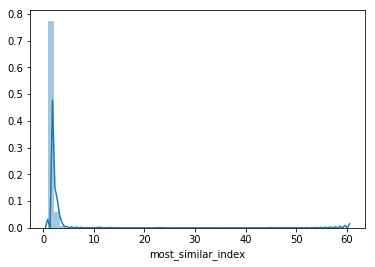

In [38]:
# there are a few stories that are deemed to be most similar to lots of other stories
sns.distplot(combined.most_similar_index.value_counts())

In [39]:
random_sample = self_joined[~self_joined.published_at.isna()].sample(n=10
                   , random_state=random_state)
random_sample

,story_id,perspective,age,lgbtq,race,topic,published_at,story_texts_x,cleaned,pos_tagged,...,sex,topic_2,female_sexuality,social_situations_at_school,puberty_first_period,feeling_sad,random/confusion,max_topic,most_similar_index,story_texts_y
136,2126,female,19.0,no,black,relationships,2019-11-05 00:00:00 UTC,I was with a group of friends at the beach nea...,I was with a group of friends at the beach nea...,"[(I, PRP), (was, VBD), (with, IN), (a, DT), (g...",...,0.000000,0.001990,0.000000,0.008386,0.000033,0.002567,0.000959,0,1778,This boy and I started off as friends but like...
1095,1008,female,15.0,yes,white,relationships,2019-03-06 00:00:00 UTC,I’ve always kinda known I was bisexual.; I fir...,Ive always kinda known I was bisexual I first ...,"[(Ive, NNP), (always, RB), (kinda, VBD), (know...",...,0.000000,0.038222,0.000000,0.000000,0.007585,0.000000,0.000000,0,1676,At the time I was dating this girl for almost ...
1949,71,male,NaN,NaN,NaN,relationships,2017-10-04 00:00:00 UTC,My sister constantly annoys me and when I figh...,My sister constantly annoys me and when I figh...,"[(My, PRP$), (sister, NN), (constantly, RB), (...",...,0.000000,0.000000,0.000000,0.000000,0.009266,0.002779,0.000372,0,1587,My boyfriend of two years and I were just hang...
1021,1084,female,15.0,no,latinx,bullying,2019-05-06 00:00:00 UTC,When I was in middle school I felt disgusting ...,When I was in middle school I felt disgusting ...,"[(When, WRB), (I, PRP), (was, VBD), (in, IN), ...",...,0.000000,0.095487,0.000000,0.000000,0.000000,0.002049,0.000000,2,148,I was with a girl I hung out with a few times ...
1699,323,female,NaN,NaN,NaN,relationships,2019-09-30 00:00:00 UTC,So I had this boyfriend. I started dating him ...,So I had this boyfriend I started dating him i...,"[(So, RB), (I, PRP), (had, VBD), (this, DT), (...",...,0.003458,0.000000,0.002144,0.000000,0.001866,0.008465,0.000000,0,1629,So I had this boyfriend. I started dating him ...
1388,677,not-shared,13.0,no,white,puberty,2019-10-13 00:00:00 UTC,At the time I was in my bathroom ; I felt real...,At the time I was in my bathroom I felt reall...,"[(At, IN), (the, DT), (time, NN), (I, PRP), (w...",...,0.000000,0.000000,0.000000,0.000000,0.037458,0.000000,0.000000,0,1853,I was staying the night at a friends and her b...
1830,190,female,NaN,NaN,NaN,puberty,2018-10-26 00:00:00 UTC,"One day, I was taking my shower; I was washing...",One day I was taking my shower I was washing m...,"[(One, CD), (day, NN), (I, PRP), (was, VBD), (...",...,0.000000,0.003269,0.000000,0.004460,0.017086,0.002614,0.002702,0,1550,So this is year I was in 5th grade. I started ...
1888,132,female,NaN,NaN,NaN,puberty,2018-11-03 00:00:00 UTC,I shaved and it was very itchy and bumpy; I bo...,I shaved and it was very itchy and bumpy I bou...,"[(I, PRP), (shaved, VBD), (and, CC), (it, PRP)...",...,0.000239,0.000000,0.000000,0.001157,0.000000,0.000000,0.000000,0,33,They were my guys best friend.; They made me f...
1410,655,female,16.0,no,native,relationships,2019-09-04 00:00:00 UTC,I thought I was in a healthy relationship when...,I thought I was in a healthy relationship when...,"[(I, PRP), (thought, VBD), (I, PRP), (was, VBD...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1823,I met this guy and I really liked him. He alwa...
1414,651,female,18.0,no,black,relationships,2019-10-13 00:00:00 UTC,I used to date my best friend and I knew from...,I used to date my best friend and I knew from...,"[(I, PRP), (used, VBD), (to, TO), (date, NN), ...",...,0.000000,0.057980,0.000000,0.000000,0.000000,0.000000,0.000000,2,1736,"So I’m a growing, young boy and lately I've re..."


In [40]:
# looking at the recommended stories
random_sample.iloc[0]['story_texts_x'], random_sample.iloc[0]['story_texts_y']

('I was with a group of friends at the beach near our school. ; We’d just finished having a picnic lunch and were laying in the sand until it was time for us to head back to school. ; I asked my friend if it would be alright for me to put my head in her lap.; She apologized and told me that she would prefer if I didn’t.; I wasn’t expecting her to say no, so I was surprised, but I was fine with it. I asked her a question and she answered me honestly.; I said ok and continued laying like I’d been doing before.',
 "This boy and I started off as friends but like a month later we started dating; The relationship was weird because we didn't talk to each other at all when we saw each other at school; But, we were always on the phone; I started hearing rumors about him cheating so we broke up be we still texted eachother and flirted; I would get mad whenever he didn't answer my calls or text me back. I was so confused because I didn't know if I wanted him or not.; Even though we texted and Fac

## Are there patterns with these topics?

In [ ]:
sns.catplot(x='crushes_on_guys', y='perspective', kind='box', data=combined)

In [ ]:
sns.catplot(x='crushes_on_guys', y='topic', kind='box', data=combined) 
# proves that there are better ways to categorize stories

In [ ]:
sns.catplot(x='crushes_on_guys', y='lgbtq', kind='box', data=combined) 

In [ ]:
# are kids talking about sex more than any other topic?
# i dont think scatter plot is the best way to visualize this interaction....
sns.scatterplot(x='age', y='sex', data=combined[combined.age<100]) # removed the obvious bad answers

In [ ]:
sns.scatterplot(x='age', y='female_sexuality', data=combined[combined.age<100])

In [ ]:
topics.values()

In [ ]:
sns.scatterplot(x='age', y='social_situations_at_school', data=combined[combined.age<100])

In [ ]:
sns.scatterplot(x='age', y='puberty_first_period', data=combined[combined.age<100])

In [ ]:
sns.scatterplot(x='age', y='crushes_on_guys', data=combined[combined.age<100])

In [ ]:
combined.info()

In [ ]:
sns.boxplot(combined.age)

In [ ]:
combined.iloc[0]

In [ ]:
combined.iloc[156]

In [ ]:
combined.iloc[2012]

In [ ]:
combined.iloc[1577]

In [ ]:
combined.shape

In [ ]:
combined.iloc[0]

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2
            , verbose=1
            , perplexity=500
            , n_iter=400
            , random_state=random_state)

In [ ]:
tfidf_tsne_data = tsne.fit_transform(tfidf_nmf_data)

In [ ]:
plt.rcParams.update({'figure.figsize': (10, 10)})
sns.scatterplot(tfidf_tsne_data[:, 0], tfidf_tsne_data[:, 1],
                size = 2, palette = 'coolwarm', alpha = 'auto', 
               markers = '.')

In [ ]:
feature_columns = tfidf_nmf_weights.columns

In [ ]:
plt.rcParams.update({'figure.figsize': (10, 120)})
for i in range(len(feature_columns)):
    plt.subplot(len(feature_columns), 1, i+1)
    sns.scatterplot(tfidf_tsne_data[:, 0], tfidf_tsne_data[:, 1]
                    ,hue=tfidf_nmf_weights[feature_columns[i]]
                , size = 2, palette = 'coolwarm', alpha = 'auto', 
               markers = '.')
    plt.title(f'Feature: {feature_columns[i]}');

## it would be interesting to know the distribution of topics and the relationship with the predetermined topics from myhealthed

## How many clusters can i find to see if this works for topic modeling

In [ ]:
from sklearn.decomposition import SparsePCA, TruncatedSVD

from sklearn.utils.extmath import randomized_svd

# U, Sigma, VT = randomized_svd

In [ ]:
# need to reduce the dimensions
random_state=42
svd = TruncatedSVD(random_state=random_state, n_components=2)

In [ ]:
svd_results = svd.fit_transform(X=tfidf_dtm)

In [ ]:
svd_results

In [ ]:
len(svd_results)

In [ ]:
stories_data[['svd_component_1', 'svd_component_2']] =pd.DataFrame(svd_results)

stories_data.head()

In [ ]:
sns.scatterplot(data=stories_data
                , x=stories_data.svd_component_1, y=stories_data.svd_component_2, hue='topic')

## what if we try to reduce the dimensions and cluster and compare the centroids to identify themes in the clusters as a way of topic modeling? 

so far im not getting a lot of progress with topic modeling so i want to try something different

In [ ]:
tfidf_dtm.shape # over 18k parameters that i need to reduce

In [ ]:
svd = TruncatedSVD(n_components=5000 # this is still a lot of parameters to fit a model....
                , random_state=random_state)

svd_fitted = svd.fit_transform(tfidf_dtm)

In [ ]:
np.cumsum(svd.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(svd.explained_variance_ratio_)) # i want to achieve 
# this can be used to find the elbow of the plot to find the optimal number of components

In [ ]:
tfidf_dtm.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [ ]:
svd.explained_variance_ratio_.sum()

In [ ]:
print(len(np.cumsum(svd.explained_variance_ratio_)))

In [ ]:
svd.components_.

In [ ]:
svd.explained_variance_ratio_